In [1]:
import json
import torch
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from tqdm import tqdm
from sklearn.metrics import f1_score
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
BASE_PATH = "/home/usiriko/8430DeepLearning/Assignment3/"
spoken_train = "spoken_train-v1.1.json"
spoken_test = "spoken_test-v1.1.json"
spoken_test_WER44 = "spoken_test-v1.1_WER44.json"
spoken_test_WER54 = "spoken_test-v1.1_WER54.json"

def read_json_data(path):
    contexts = []
    questions = []
    answers = []
    
    with open(path, 'r') as file:
        raw_data = json.load(file)

    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context.lower())
                    questions.append(question.lower())
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_json_data(os.path.join(BASE_PATH, spoken_train))
valid_contexts, valid_questions, valid_answers = read_json_data(os.path.join(BASE_PATH, spoken_test))
valid_contexts_44, valid_questions_44, valid_answers_44 = read_json_data(os.path.join(BASE_PATH, spoken_test_WER44))
valid_contexts_54, valid_questions_54, valid_answers_54 = read_json_data(os.path.join(BASE_PATH, spoken_test_WER54))

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased').to(device)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
class SpokenSQuADDataset(Dataset):
    def __init__(self, contexts, questions, answers, tokenizer, max_length=512, doc_stride=128):
        self.contexts = contexts
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.doc_stride = doc_stride

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        answer = self.answers[idx]
        
        start_char = answer['answer_start']
        end_char = start_char + len(answer['text'])
        
        encoding = self.tokenizer(
            question,
            context,
            max_length=self.max_length,
            stride=self.doc_stride,
            padding="max_length",
            truncation=True,
            return_offsets_mapping=True
        )
        
        start_token = end_token = None
        for i, (offset_start, offset_end) in enumerate(encoding['offset_mapping']):
            if offset_start <= start_char < offset_end:
                start_token = i
            if offset_start < end_char <= offset_end:
                end_token = i
                break

        if start_token is None:
            start_token = 0
        if end_token is None:
            end_token = 0

        encoding['start_positions'] = start_token
        encoding['end_positions'] = end_token

        return {k: torch.tensor(v).to(device) for k, v in encoding.items()}

In [4]:
EPOCHS = 15

train_dataset = SpokenSQuADDataset(train_contexts, train_questions, train_answers, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataloader) * EPOCHS  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
scaler = torch.amp.GradScaler()

In [5]:
loss_arr = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()

        with autocast('cuda'):
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                start_positions=batch['start_positions'],
                end_positions=batch['end_positions']
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    avg_loss = epoch_loss / len(train_dataloader)
    loss_arr.append(avg_loss)
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss}")

Epoch 1 completed. Average Loss: 2.2431903549452543


Epoch 2 completed. Average Loss: 1.385352760810332


Epoch 3 completed. Average Loss: 0.9156529948767416


Epoch 4 completed. Average Loss: 0.6222421323627998


Epoch 5 completed. Average Loss: 0.43186097195414946


Epoch 6 completed. Average Loss: 0.30426727213474614


Epoch 7 completed. Average Loss: 0.2128696227383963


Epoch 8 completed. Average Loss: 0.15401774194026513


Epoch 9 completed. Average Loss: 0.11290468511138112


Epoch 10 completed. Average Loss: 0.0823314170204352


Epoch 11 completed. Average Loss: 0.05833556942318914


Epoch 12 completed. Average Loss: 0.04506526365201646


Epoch 13 completed. Average Loss: 0.035213588898964136


Epoch 14 completed. Average Loss: 0.02611207609066709


Epoch 15 completed. Average Loss: 0.020329534536896916


In [13]:
import numpy as np

def f1(predictions, references):
    f1_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = set(pred.split())
        ref_tokens = set(ref.split())
        
        common_tokens = pred_tokens.intersection(ref_tokens)
        num_same = len(common_tokens)
        
        if num_same == 0:
            f1_scores.append(0)
        else:
            precision = num_same / len(pred_tokens)
            recall = num_same / len(ref_tokens)
            f1 = (2 * precision * recall) / (precision + recall)
            f1_scores.append(f1)
    
    return np.mean(f1_scores)

In [14]:
def evaluate(model, contexts, questions, answers):
    model.eval()
    predictions = []
    references = [answer['text'] for answer in answers]
    
    for question, context in zip(questions, contexts):
        inputs = tokenizer(question, context, return_tensors="pt", max_length=512, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            start_scores = outputs.start_logits
            end_scores = outputs.end_logits
            start_index = torch.argmax(start_scores)
            end_index = torch.argmax(end_scores)
            answer_tokens = inputs["input_ids"][0][start_index:end_index + 1]
            predicted_answer = tokenizer.decode(answer_tokens)
            predictions.append(predicted_answer)
    
    return f1(predictions, references)

In [15]:
f1_test = evaluate(model, valid_contexts, valid_questions, valid_answers)
f1_test_WER44 = evaluate(model, valid_contexts_44, valid_questions_44, valid_answers_44)
f1_test_WER54 = evaluate(model, valid_contexts_54, valid_questions_54, valid_answers_54)

print(f"F1 Score on Test Data: {f1_test}")
print(f"F1 Score on Test Data WER44: {f1_test_WER44}")
print(f"F1 Score on Test Data WER54: {f1_test_WER54}")

print("Loss array:", loss_arr)

F1 Score on Test Data: 0.541481368800795
F1 Score on Test Data WER44: 0.21586376242678107
F1 Score on Test Data WER54: 0.16514337375982194
Loss array: [2.2431903549452543, 1.385352760810332, 0.9156529948767416, 0.6222421323627998, 0.43186097195414946, 0.30426727213474614, 0.2128696227383963, 0.15401774194026513, 0.11290468511138112, 0.0823314170204352, 0.05833556942318914, 0.04506526365201646, 0.035213588898964136, 0.02611207609066709, 0.020329534536896916]


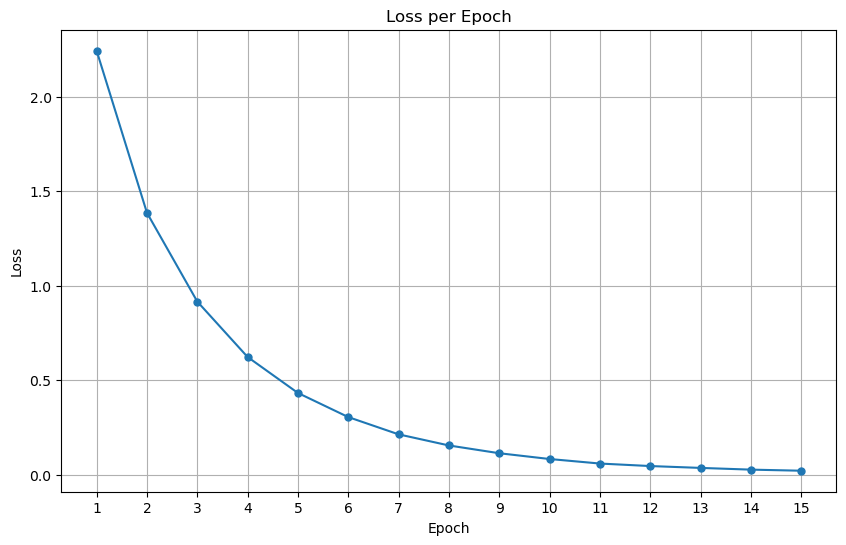

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_arr) + 1), loss_arr, marker='o', linestyle='-', markersize=5)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, len(loss_arr) + 1))
plt.grid(True)
plt.show()